In [492]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import math
from collections import defaultdict
from sklearn.cluster import DBSCAN
from scipy.signal import savgol_filter

In [493]:
def define_roi(img, max_display_size=800, window_name="Select ROI"):
    """
    Displays a resizable window for ROI selection, then returns the cropped ROI from the original image.

    Parameters:
    - img: np.ndarray, the original image
    - max_display_size: int, maximum width or height to resize image for display (default: 800)
    - window_name: str, name of the selection window

    Returns:
    - cropped_img: np.ndarray, the cropped region of interest from the original image
    - (x, y, w, h): tuple of ROI coordinates in the original image
    """
    orig_h, orig_w = img.shape[:2]
    scale = min(max_display_size / orig_w, max_display_size / orig_h, 1.0)

    # Resize image for easier selection
    resized_w, resized_h = int(orig_w * scale), int(orig_h * scale)
    resized_image = cv2.resize(img, (resized_w, resized_h))

    # Let user select ROI
    roi = cv2.selectROI(window_name, resized_image, showCrosshair=True, fromCenter=False)
    cv2.destroyAllWindows()

    # Convert ROI coordinates back to original scale
    x, y, w, h = roi
    x = int(x / scale)
    y = int(y / scale)
    w = int(w / scale)
    h = int(h / scale)

    cropped_img = img[y:y+h, x:x+w]
    return cropped_img, (x, y, w, h)

def hist_equalize(img):
    '''
    Histogram equalization for grayscale or color images.
    '''
    if len(img.shape) == 2:
        equalized_img = cv2.equalizeHist(img)
    else:
        channels = cv2.split(img)
        equalized_channels = [cv2.equalizeHist(ch) for ch in channels]
        equalized_img = cv2.merge(equalized_channels)

    return equalized_img

def preprocess_img(img, ksize=5, canny_low_thresh=30, canny_up_thresh=100):
    '''
    Convert to gray, equalize histogram, denoise using Gaussian, and detect edges
    before finding the outlines.
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = hist_equalize(gray)
    # blur = cv2.GaussianBlur(equalized, (ksize, ksize), 0)
    blur = cv2.bilateralFilter(equalized, d=5, sigmaColor=15, sigmaSpace=10) # avoids blurring the edges
    edges = cv2.Canny(blur, canny_low_thresh, canny_up_thresh)
    
    return edges

In [496]:
def group_by_row(contours):
    grouped = defaultdict(list)  # maps y -> list of (x, y)

    for c in contours:
        for point in c:
            x, y = point[0]
            grouped[y].append((x, y))

    # Sort each row's points by x
    grouped_sorted = []
    for y in sorted(grouped.keys()):
        row = sorted(grouped[y], key=lambda pt: pt[0])
        grouped_sorted.append(row)

    return grouped_sorted

def filter_contours(contours, pts_fraction=0.1, alpha=0.5):
    filtered_contours = []
    grouped_contours = group_by_row(contours)

    if not grouped_contours:
        return []

    prev_left = grouped_contours[0][0][0]
    prev_right = grouped_contours[0][-1][0]

    for row in grouped_contours:
        y_value = row[0][1]

        row = sorted(row, key=lambda pt: pt[0])  # sort by x
        N = len(row)
        pts_thresh = max(1, int(N * pts_fraction))

        x_left = [pt[0] for pt in row[:pts_thresh]]
        x_right = [pt[0] for pt in row[-pts_thresh:]]

        x_min = np.mean(x_left)
        x_max = np.mean(x_right)

        # Exponential smoothing for continuity
        x_min = alpha * x_min + (1 - alpha) * prev_left
        x_max = alpha * x_max + (1 - alpha) * prev_right

        filtered_contours.append([(x_min, y_value), (x_max, y_value)])
        prev_left, prev_right = x_min, x_max

    return filtered_contours

def get_contours(edge, min_area = 100):
    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    larger_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_area]
    return filter_contours(contours)

def get_contours_only(edge):
    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

In [497]:
def plot_filtered_contour_outline(filtered_contours):
    # Extract left and right edges
    left_edge = [pt[0] for pt in filtered_contours]   # left side
    right_edge = [pt[1] for pt in filtered_contours]  # right side

    # Connect the outline: left edge (top→bottom), then right edge (bottom→top)
    outline = left_edge + right_edge[::-1]

    # Unzip x and y for plotting
    x_vals, y_vals = zip(*outline)

    return x_vals, y_vals


def remove_bg(image, filtered_contours, background_color=(0, 0, 0)):
    """
    Removes background by keeping pixels between (x_min, x_max) on each y-row.
    
    Args:
        image: The original RGB image (NumPy array).
        filtered_contours: List of [(x_min, y), (x_max, y)] pairs for each row.
        background_color: Color to assign to background pixels (default: black).
        
    Returns:
        Masked image with background removed.
    """
    masked_img = image.copy()

    for (x_min, y), (x_max, _) in filtered_contours:
        x_min = int(max(0, x_min))
        x_max = int(min(image.shape[1] - 1, x_max))
        y = int(y)
        
        # Set pixels to the left of x_min and right of x_max to background color
        if y >= 0 and y < image.shape[0]:
            masked_img[y, :x_min] = background_color
            masked_img[y, x_max+1:] = background_color

    return masked_img

def merge_layers(original_img, cropped_img, mask, ROI_coords, blur_ksize=(21, 21), sigma=0):
    x, y, w, h = ROI_coords

    # Step 1: Blur the original image
    blurred_img = cv2.GaussianBlur(original_img, blur_ksize, sigma)

    # Step 2: Prepare empty foreground and mask canvases
    foreground = np.zeros_like(original_img)
    mask_full = np.zeros(original_img.shape[:2], dtype=np.uint8)

    # Step 3: Ensure mask is single-channel binary
    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, mask_bin = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

    # Step 4: Paste cropped image and mask into correct location
    h_crop, w_crop = cropped_img.shape[:2]
    foreground[y:y+h_crop, x:x+w_crop] = cropped_img
    mask_full[y:y+h_crop, x:x+w_crop] = mask_bin

    # Step 5: Composite like Photoshop (use mask to select from foreground or background)
    combined = np.where(mask_full[..., None] == 255, foreground, blurred_img)

    return combined

In [498]:
img_path = "../images/beach.jpg"
# img_path = "segmented_clay.png"
img = cv2.imread(img_path)

# Obtain region of interest (ROI)
cropped_img, roi_points = define_roi(img)
img_edges = preprocess_img(cropped_img)
contours = get_contours(img_edges)
contours_only = get_contours_only(img_edges)

mask = np.zeros_like(cropped_img)  # grayscale image same size as input
# cv2.drawContours(mask, contours, -1, (70, 100, 255), thickness=1)

background_removed = remove_bg(cropped_img, contours)
final_output = merge_layers(img, cropped_img, background_removed, roi_points, (25, 25), 5)

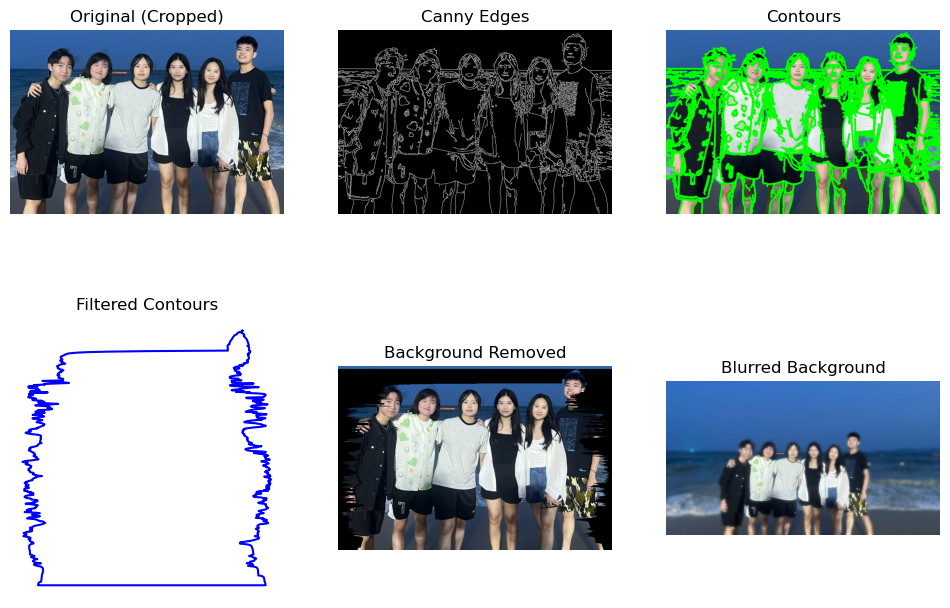

In [499]:
# for subplot 3
contours_img = cropped_img.copy()
contours_img = cv2.cvtColor(contours_img, cv2.COLOR_BGR2RGB)
contours_img = cv2.drawContours(contours_img,  contours_only, -1, (0,255,0), 3)

# for subplot 4
x_vals, y_vals = plot_filtered_contour_outline(contours)

# Display All
plt.figure(figsize=(12, 8))

plt.subplot(231); plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)); plt.title('Original (Cropped)'); plt.axis('off')
plt.subplot(232); plt.imshow(img_edges, cmap="gray"); plt.title('Canny Edges'); plt.axis('off')
plt.subplot(233); plt.imshow(contours_img); plt.title('Contours'); plt.axis('off')
plt.subplot(234); plt.plot(x_vals, y_vals, color='blue'); plt.gca().invert_yaxis(); plt.title('Filtered Contours'); plt.axis('off')
plt.subplot(235); plt.imshow(cv2.cvtColor(background_removed, cv2.COLOR_BGR2RGB)); plt.title('Background Removed'); plt.axis('off')
plt.subplot(236); plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB)); plt.title('Blurred Background'); plt.axis('off')

plt.show()

In [254]:
# cv2.imwrite('test.png', final_output)

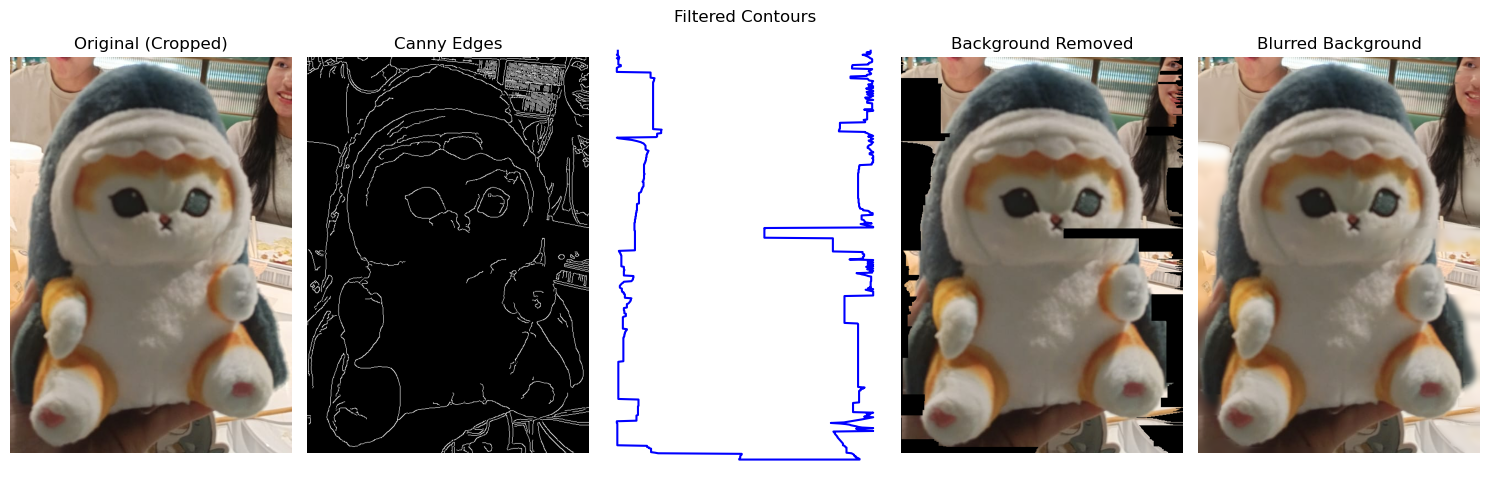

In [137]:
# Display All
plt.figure(figsize=(15, 5))

plt.subplot(151)
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.title('Original (Cropped)')
plt.axis('off')

plt.subplot(152)
plt.imshow(img_edges, cmap="gray")
plt.title('Canny Edges')
plt.axis('off')

plt.subplot(153)
x_vals, y_vals = plot_filtered_contour_outline(contours)
plt.plot(x_vals, y_vals, color='blue')
plt.gca().invert_yaxis()
plt.title('Filtered Contours')
plt.axis('off')


plt.subplot(154)
plt.imshow(cv2.cvtColor(background_removed, cv2.COLOR_BGR2RGB))
plt.title('Background Removed')
plt.axis('off')


plt.subplot(155)
plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB))
plt.title('Blurred Background')
plt.axis('off')

plt.tight_layout()
plt.show()

In [191]:
def color_segmentation(img, k=2):
    Z = img.reshape((-1, 3)).astype(np.float32)
    _, labels, centers = cv2.kmeans(Z, k, None, 
        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
        attempts=5, flags=cv2.KMEANS_RANDOM_CENTERS)

    segmented = centers[labels.flatten()].reshape(img.shape).astype(np.uint8)
    mask = (labels.reshape(img.shape[:2]) == labels[0][0]).astype(np.uint8) * 255
    return segmented, mask

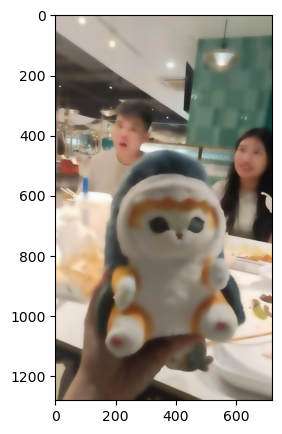

In [262]:
test = cv2.imread('../images/harmo.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
blur = cv2.bilateralFilter(test, d=25, sigmaColor=150, sigmaSpace=150)

plt.figure(figsize=(12, 5))
plt.imshow(blur)
plt.show()